# Anime recommendation based on user clustering

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Importing libraries and files

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

plt.rcParams['figure.figsize'] = (6, 4)
plt.style.use('ggplot')
%config InlineBackend.figure_formats = {'png', 'retina'}

In [0]:
anime = pd.read_csv('drive/My Drive/Anime_Recommendation_Data/anime (1).csv')

In [0]:
user = pd.read_csv('drive/My Drive/Anime_Recommendation_Data/rating.csv')

### Calculate mean rating per user

In [0]:
MRPU = user.groupby(['user_id']).mean().reset_index()
MRPU['mean_rating'] = MRPU['rating']

MRPU.drop(['anime_id','rating'],axis=1, inplace=True)

In [0]:
user = pd.merge(user,MRPU,on=['user_id','user_id'])

In [0]:
user = user.drop(user[((user.rating < user.mean_rating) & (user.rating < 8))].index)

In [0]:
user = user.rename({'rating':'userRating'}, axis='columns')

## Combine two datasets

In [0]:
mergedata = pd.merge(anime,user,on=['anime_id','anime_id'])
mergedata= mergedata[mergedata.user_id >= 0]

## Create Crosstable

In [0]:
user_anime = pd.crosstab(mergedata['user_id'], mergedata['name'])

## Principal component analysis

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(user_anime)
pca_samples = pca.transform(user_anime)

In [0]:
ps = pd.DataFrame(pca_samples)

In [0]:
tocluster = pd.DataFrame(ps[[0,1,2]])

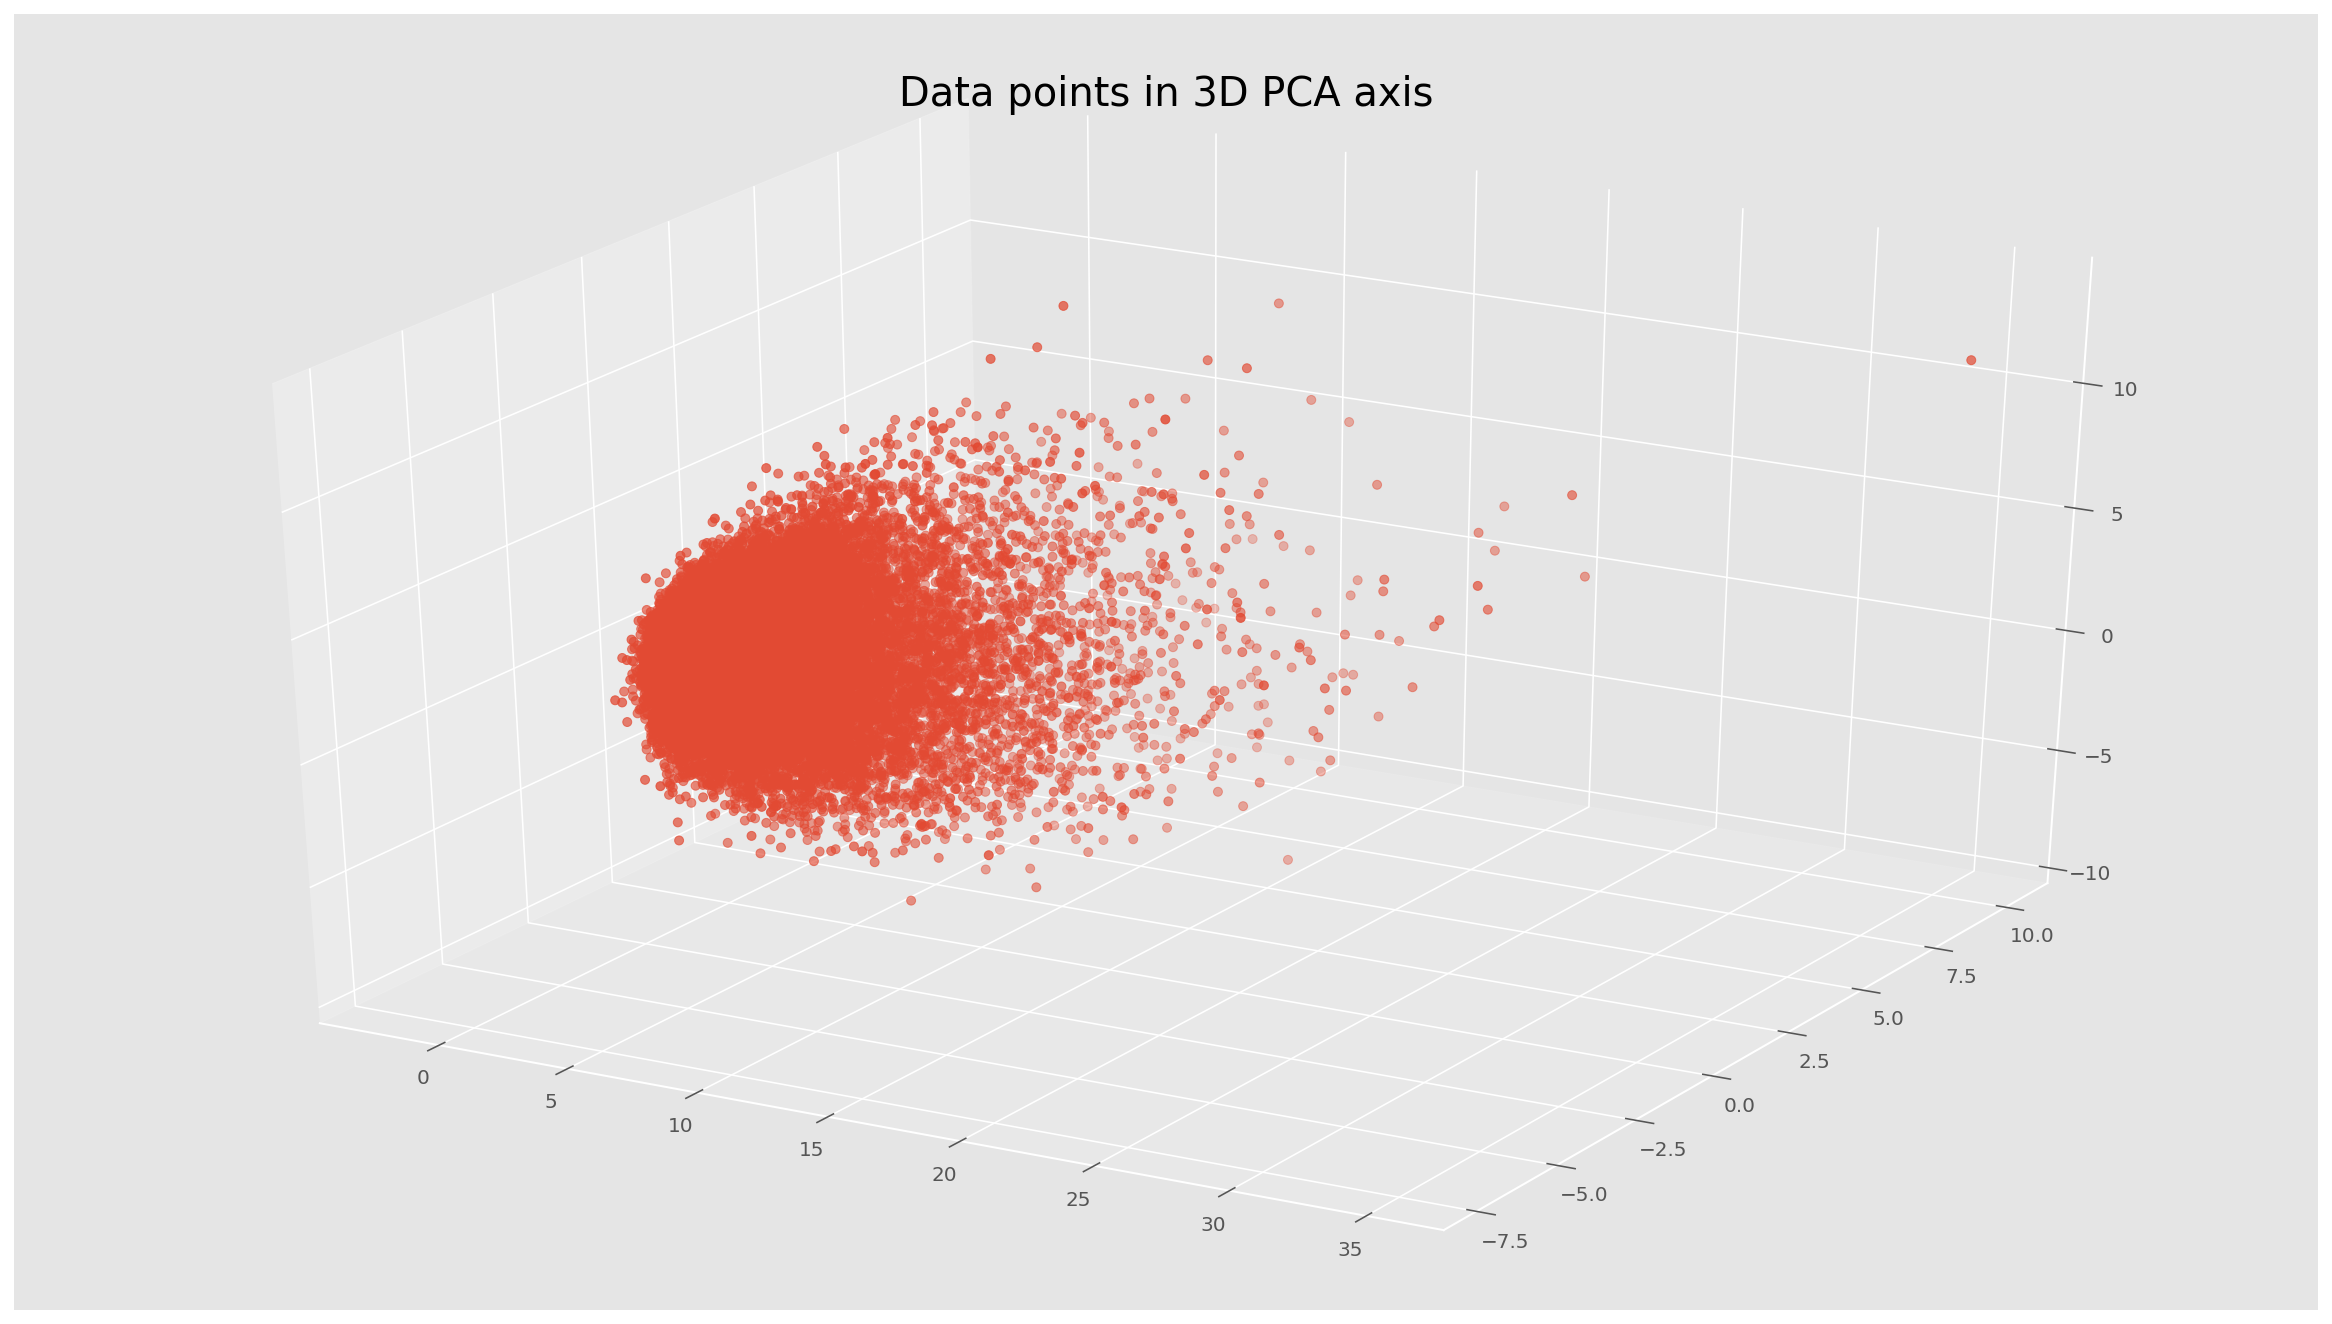

In [0]:
plt.rcParams['figure.figsize'] = (16, 9)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1])

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

## Selecting number of k

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
inertia_list = np.empty(8)

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(tocluster)
    inertia_list[i] = kmeans.inertia_
    scores.append(silhouette_score(tocluster, kmeans.labels_))

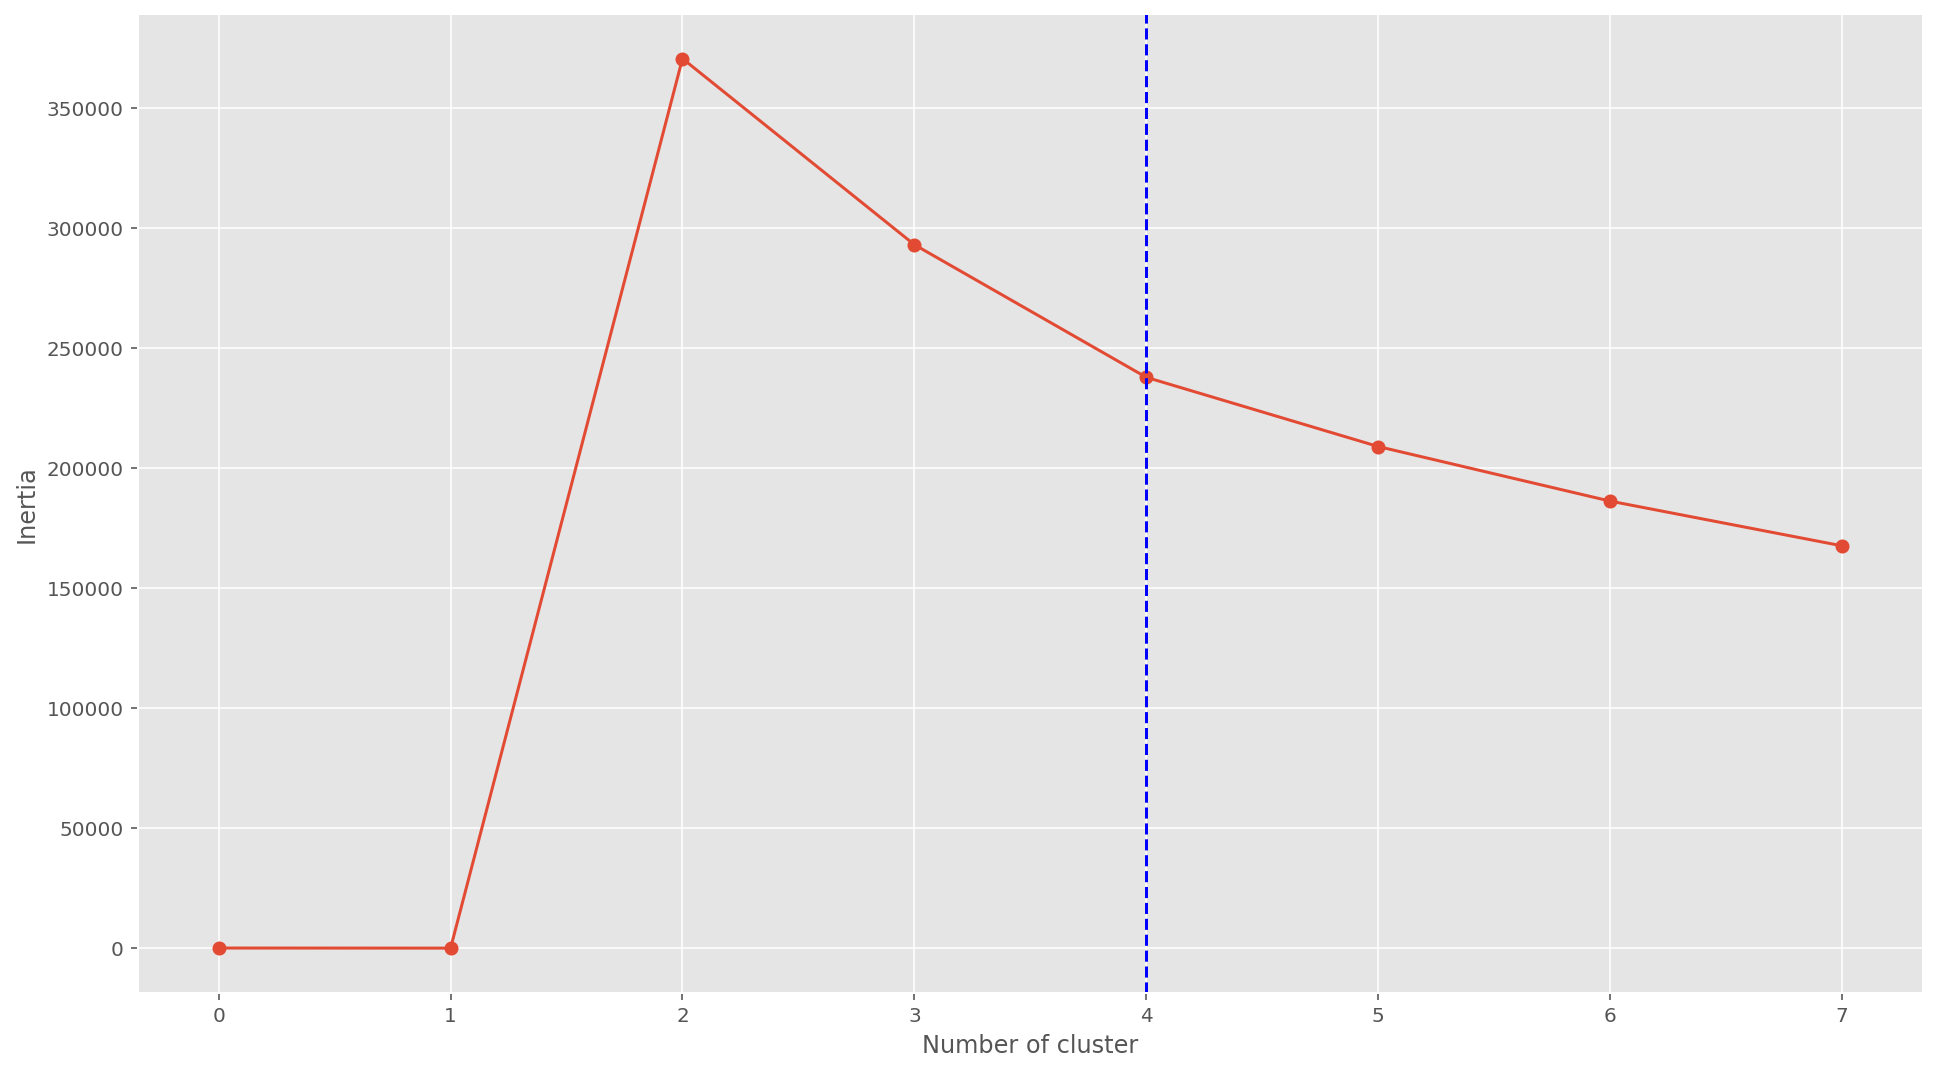

In [0]:
plt.plot(range(0,8),inertia_list,'-o')
plt.xlabel('Number of cluster')
plt.axvline(x=4, color='blue', linestyle='--')
plt.ylabel('Inertia')
plt.show()

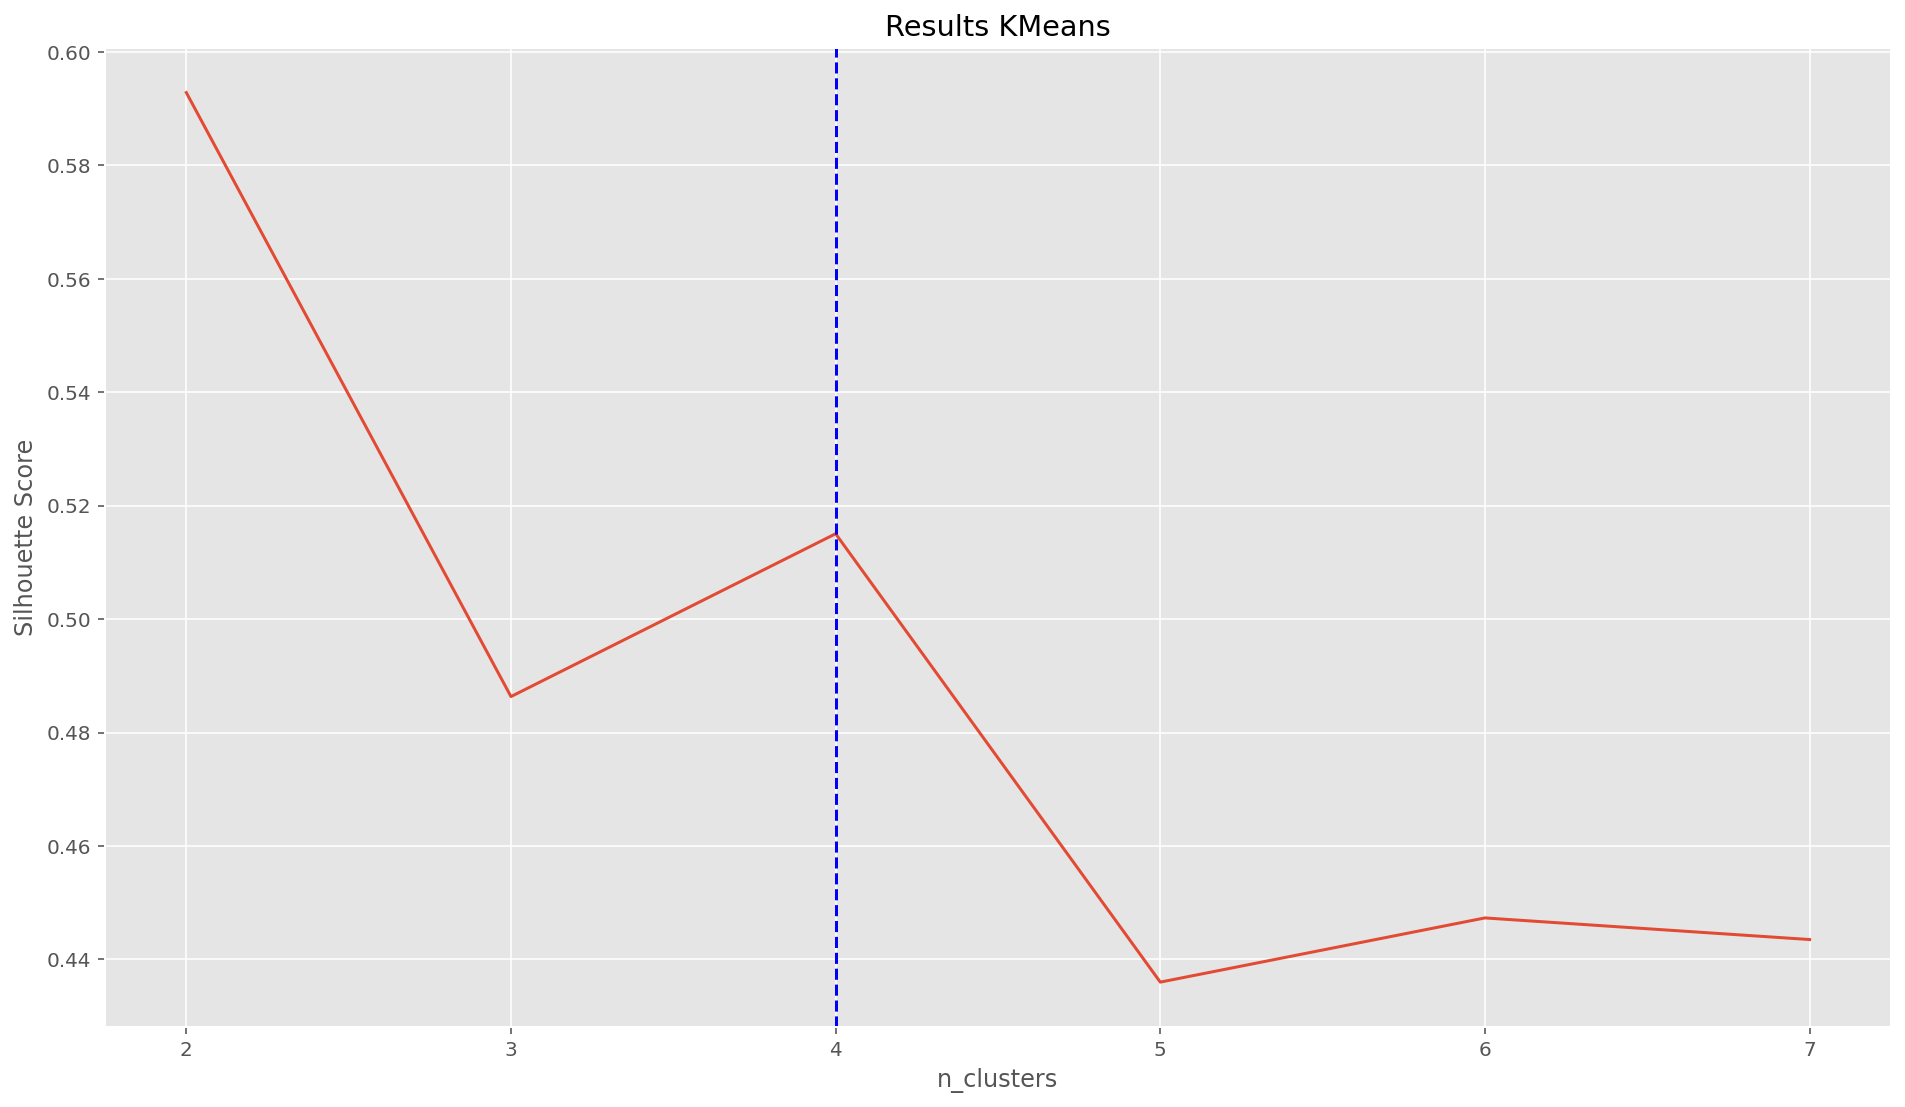

In [0]:
plt.plot(range(2,8), scores);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=4, color='blue', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

## K means clustering

In [0]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=4,random_state=30).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)

print(centers)

[[-1.21436784 -0.07446326  0.09456676]
 [ 2.0789899  -1.23443221 -0.67653795]
 [ 7.77540598 -0.81045181  1.09154157]
 [ 1.64394214  2.26893543 -0.04665874]]


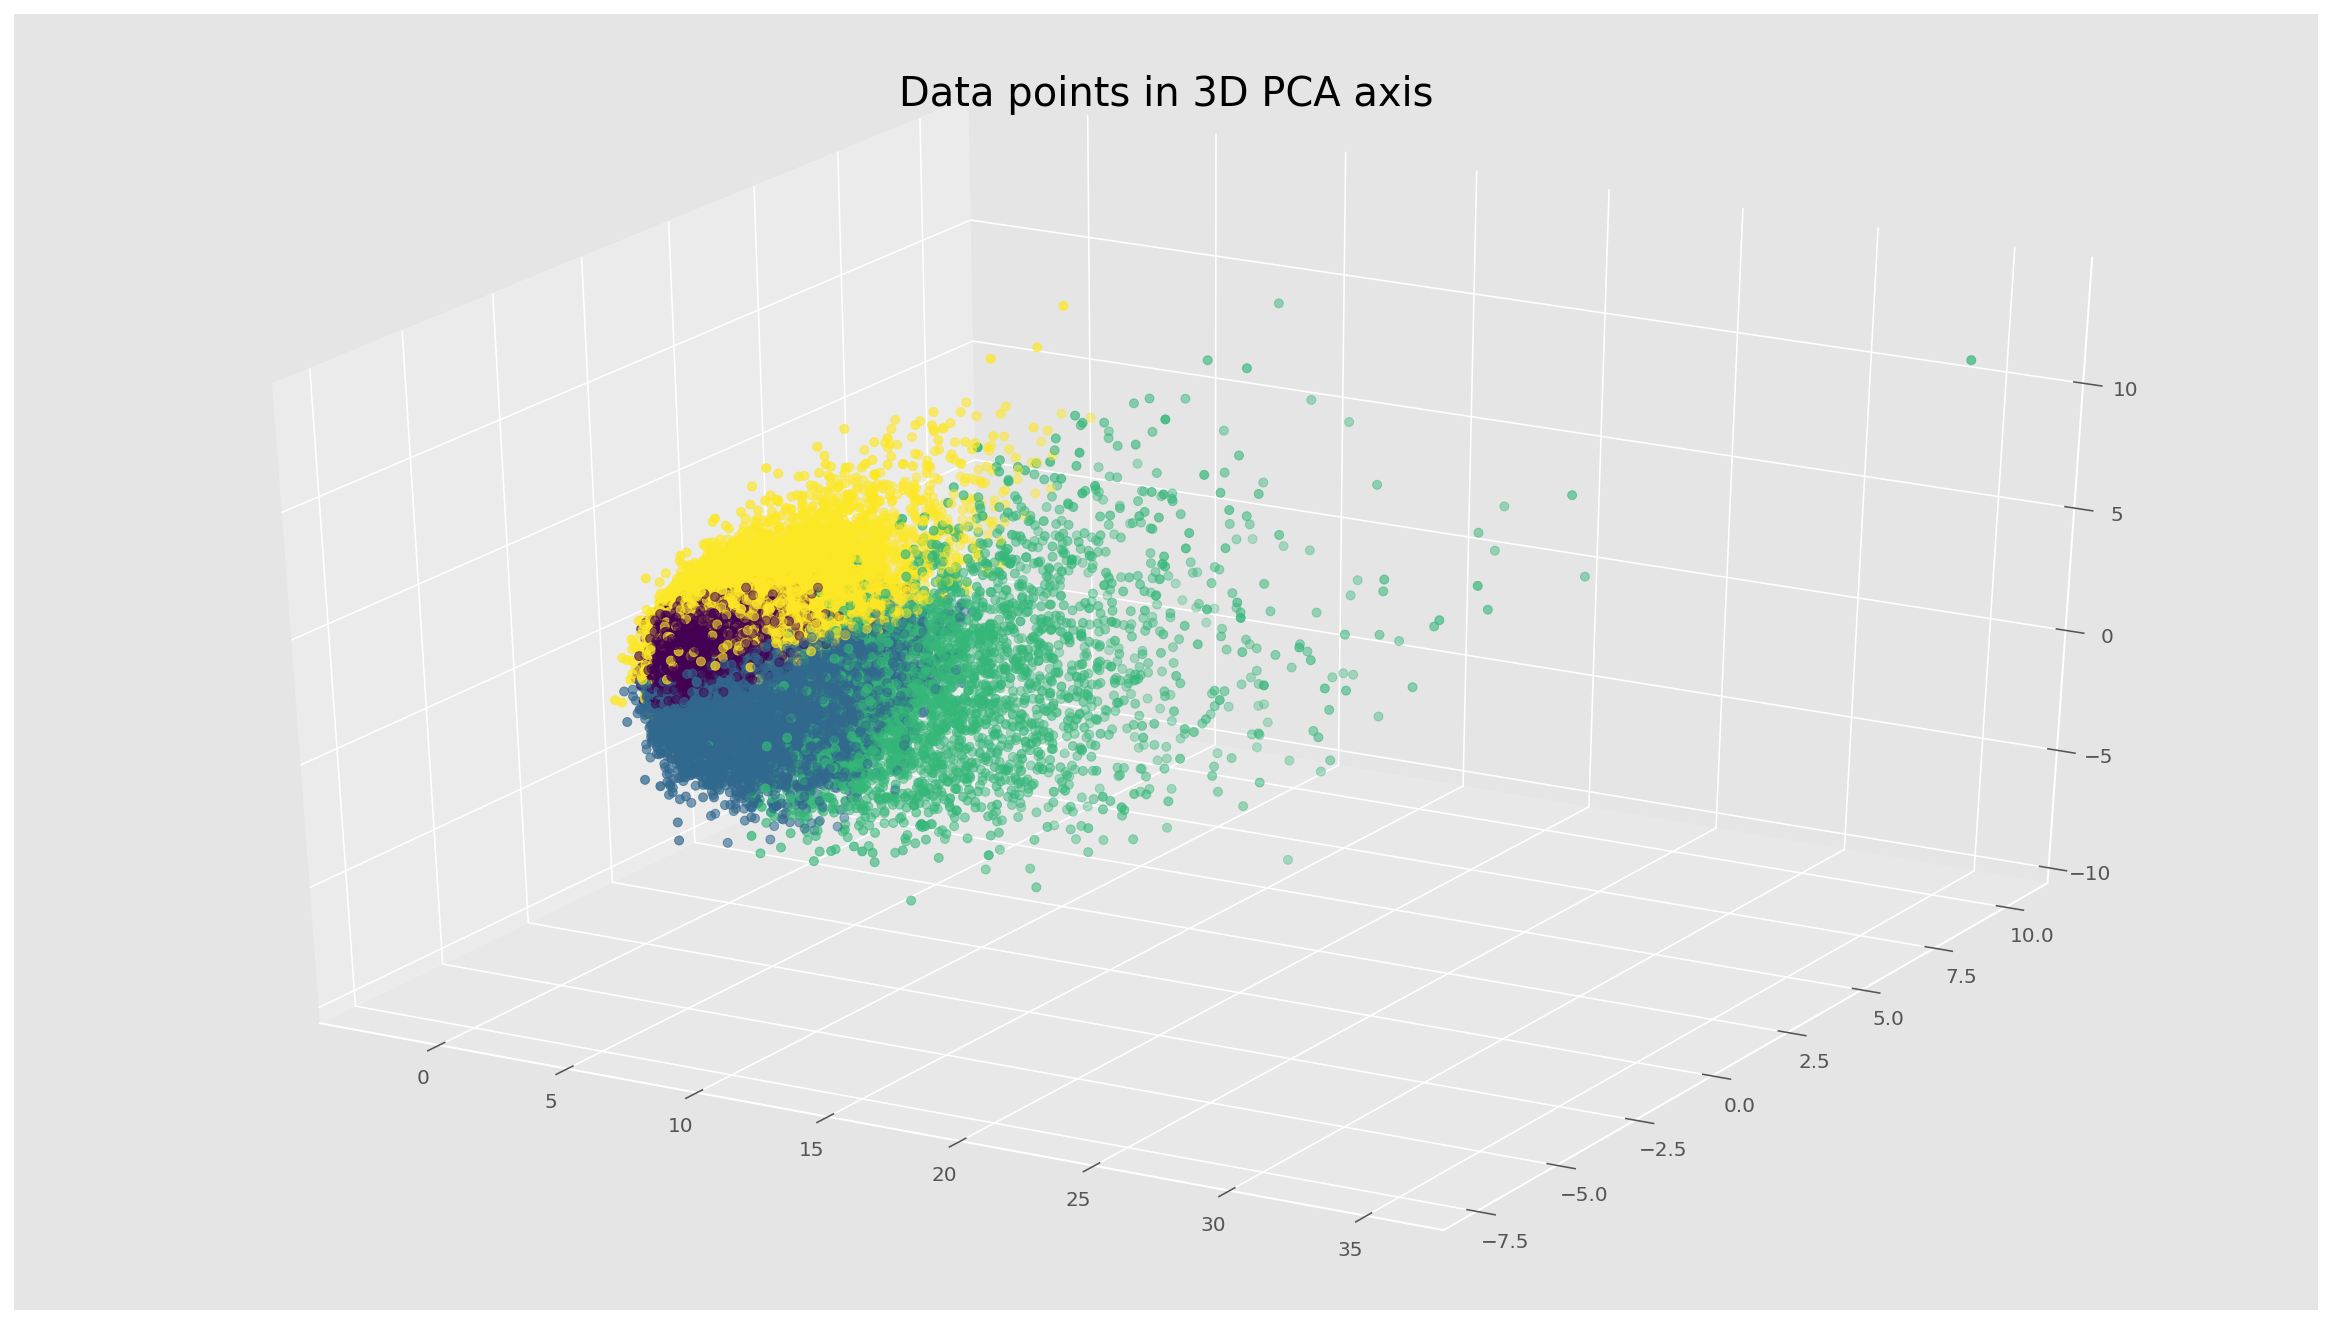

In [0]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1], c = c_preds)
plt.title('Data points in 3D PCA axis', fontsize=20)

plt.show()

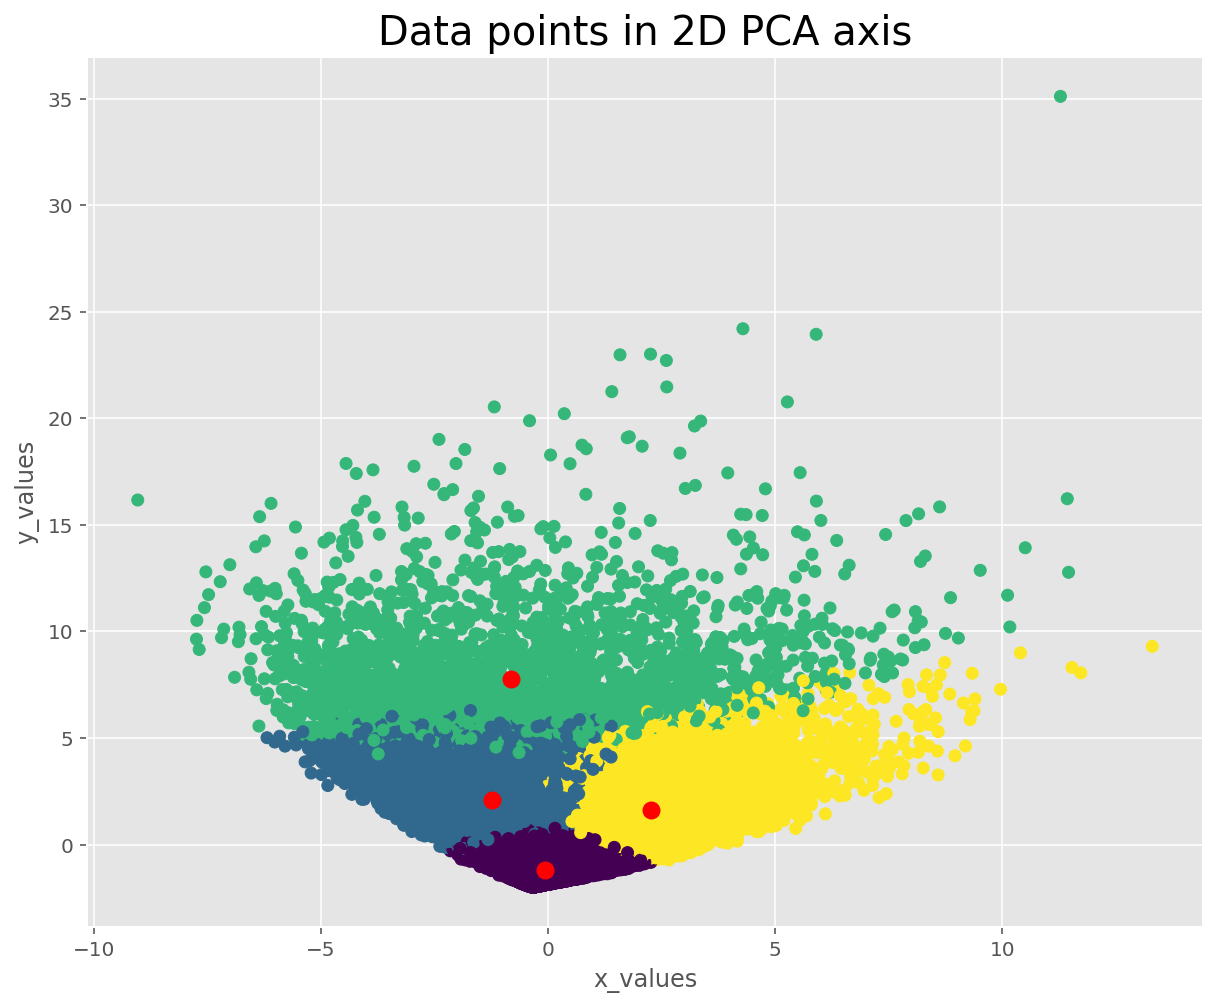

In [0]:
fig = plt.figure(figsize=(10,8))
plt.scatter(tocluster[1],tocluster[0],c = c_preds)
for ci,c in enumerate(centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points in 2D PCA axis', fontsize=20)
plt.show()

In [0]:
user_anime['cluster'] = c_preds

## Characteristic of each cluster

In [0]:
c0 = user_anime[user_anime['cluster']==0].drop('cluster',axis=1).mean()
c1 = user_anime[user_anime['cluster']==1].drop('cluster',axis=1).mean()
c2 = user_anime[user_anime['cluster']==2].drop('cluster',axis=1).mean()
c3 = user_anime[user_anime['cluster']==3].drop('cluster',axis=1).mean()

### Cluster 0

    Top 15 anime which will explain characteristic of this cluster

In [0]:
c0.sort_values(ascending=False)[0:15]

name
Death Note                            0.344756
Shingeki no Kyojin                    0.206291
Code Geass: Hangyaku no Lelouch       0.185705
Sword Art Online                      0.182254
Fullmetal Alchemist: Brotherhood      0.179081
Fullmetal Alchemist                   0.174540
Sen to Chihiro no Kamikakushi         0.173370
Naruto                                0.172973
Elfen Lied                            0.168987
Angel Beats!                          0.162700
Ouran Koukou Host Club                0.155085
Code Geass: Hangyaku no Lelouch R2    0.152646
Toradora!                             0.129085
Howl no Ugoku Shiro                   0.126210
Clannad                               0.121569
dtype: float64

In [0]:
def createAnimeInfoList(animelist):
    episode_list = list()
    genre_list = list()
    member_list = list()
    rating_list= list()
    for x in anime['name']:
        if x in animelist:
            temp = []
            episode_list.append(anime[anime['name']==x].episodes.values.astype(int))
            member_list.append(anime[anime['name']==x].members.values.astype(int))
            rating_list.append(anime[anime['name']==x].rating.values.astype(int))
            for y in anime[anime['name']==x].genre.values:
                 temp.append(y)
            genre_list.append(', '.join([str(elem) for elem in temp]))
    return genre_list,episode_list,rating_list,member_list

In [0]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split(','):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
            
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [0]:
animelist = list(c0.index)
data = pd.DataFrame()
data['genre'],data['episode'],data['rating'],data['member'] =  createAnimeInfoList(animelist)

In [0]:
set_keywords = set()
for liste_keywords in data['genre'].str.split(',').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)

In [0]:
from wordcloud import WordCloud

def makeCloud(Dict,name,color):
    words = dict()

    for s in Dict:
        words[s[0]] = s[1]

        wordcloud = WordCloud(
                      width=1500,
                      height=500, 
                      background_color=color, 
                      max_words=20,
                      max_font_size=500, 
                      normalize_plurals=False)
        wordcloud.generate_from_frequencies(words)


    fig = plt.figure(figsize=(12, 8))
    plt.title(name)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

    Favorite genre for this cluster 

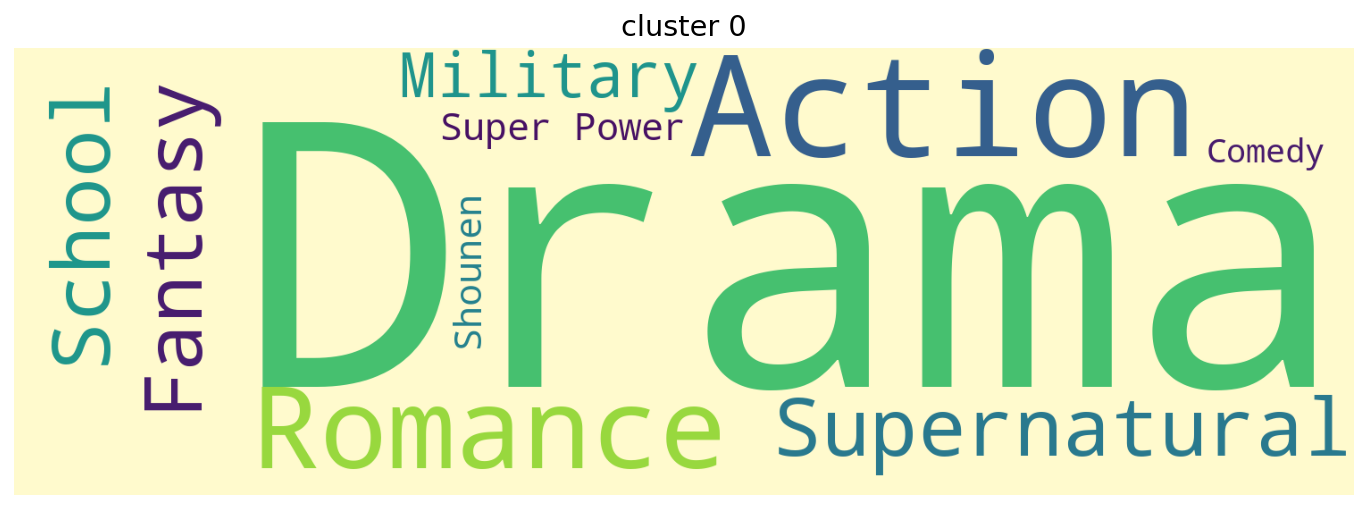

In [0]:
c0_animelist = list(c0.sort_values(ascending=False)[0:15].index)
c0_data = pd.DataFrame()
c0_data['genre'],c0_data['episode'],c0_data['rating'],c0_data['member'] =  createAnimeInfoList(c0_animelist)
c0_data.iloc[:,1:4] = c0_data.iloc[:,1:4].astype(int) # change to numeric object to integer
keyword_occurences, dum = count_word(c0_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 0","lemonchiffon")

In [0]:
keyword_occurences[0:5]

[[' Drama', 9],
 ['Action', 9],
 [' Romance', 6],
 [' Supernatural', 5],
 [' School', 5]]

    Average of each information for anime which user in this cluster like

In [0]:
print('cluster 0\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c0_data['episode'].mean(), c0_data['rating'].mean(),c0_data['member'].mean()))

cluster 0
AVG episode : 38.266666666666666
AVG movie rating : 7.866666666666666
AVG member : 662143.7333333333


### Cluster 1

In [0]:
c1.sort_values(ascending=False)[0:15]

name
Shingeki no Kyojin                    0.743816
Sword Art Online                      0.660972
No Game No Life                       0.646289
Death Note                            0.628315
Angel Beats!                          0.623954
Fullmetal Alchemist: Brotherhood      0.555882
Steins;Gate                           0.555170
Mirai Nikki (TV)                      0.545293
Toradora!                             0.542801
Code Geass: Hangyaku no Lelouch       0.519043
Tokyo Ghoul                           0.509788
Noragami                              0.493593
One Punch Man                         0.486563
Code Geass: Hangyaku no Lelouch R2    0.484428
Ao no Exorcist                        0.445720
dtype: float64

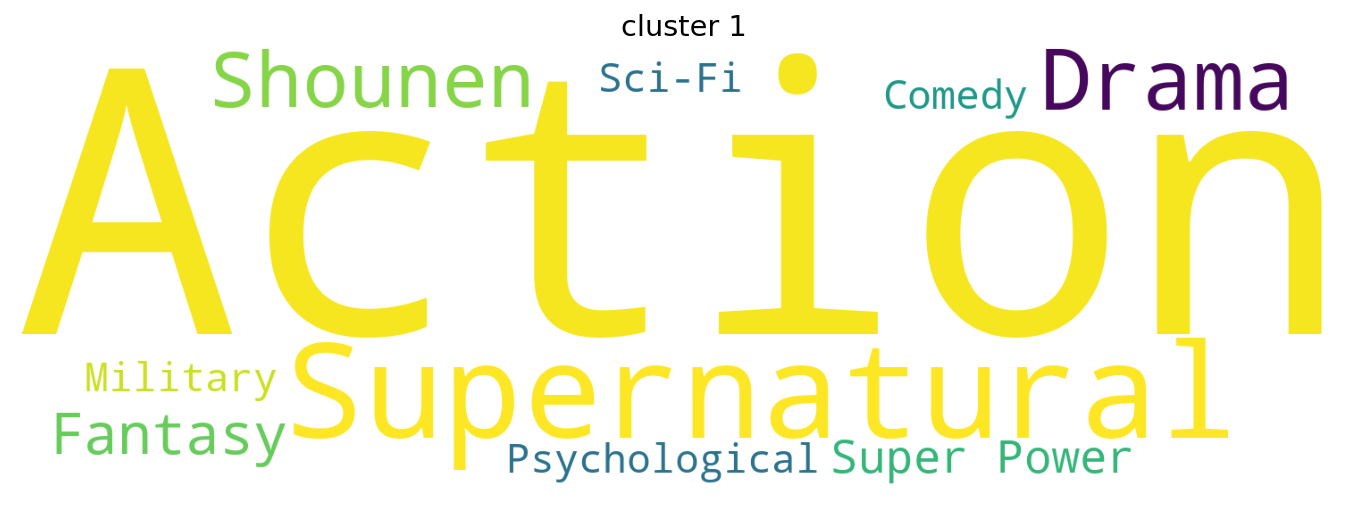

In [0]:
c1_animelist = list(c1.sort_values(ascending=False)[0:15].index)
c1_data = pd.DataFrame()
c1_data['genre'],c1_data['episode'],c1_data['rating'],c1_data['member'] =  createAnimeInfoList(c1_animelist)
c1_data.iloc[:,1:4] = c1_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c1_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 1","white")

In [0]:
keyword_occurences[0:5]

[['Action', 11],
 [' Supernatural', 8],
 [' Drama', 5],
 [' Shounen', 5],
 [' Fantasy', 5]]

In [0]:
print('cluster 1\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c1_data['episode'].mean(), c1_data['rating'].mean(),c1_data['member'].mean()))

cluster 1
AVG episode : 24.133333333333333
AVG movie rating : 8.0
AVG member : 695955.4


### Cluster 2

In [0]:
c2.sort_values(ascending=False)[0:15]

name
Angel Beats!                                           0.873744
Toradora!                                              0.840924
Sword Art Online                                       0.830877
No Game No Life                                        0.796048
Shingeki no Kyojin                                     0.795044
Code Geass: Hangyaku no Lelouch                        0.785332
Hataraku Maou-sama!                                    0.766912
Bakemonogatari                                         0.763563
Steins;Gate                                            0.761889
Code Geass: Hangyaku no Lelouch R2                     0.755861
Clannad                                                0.736437
Death Note                                             0.730409
Boku wa Tomodachi ga Sukunai                           0.727395
Mirai Nikki (TV)                                       0.725720
Yahari Ore no Seishun Love Comedy wa Machigatteiru.    0.724715
dtype: float64

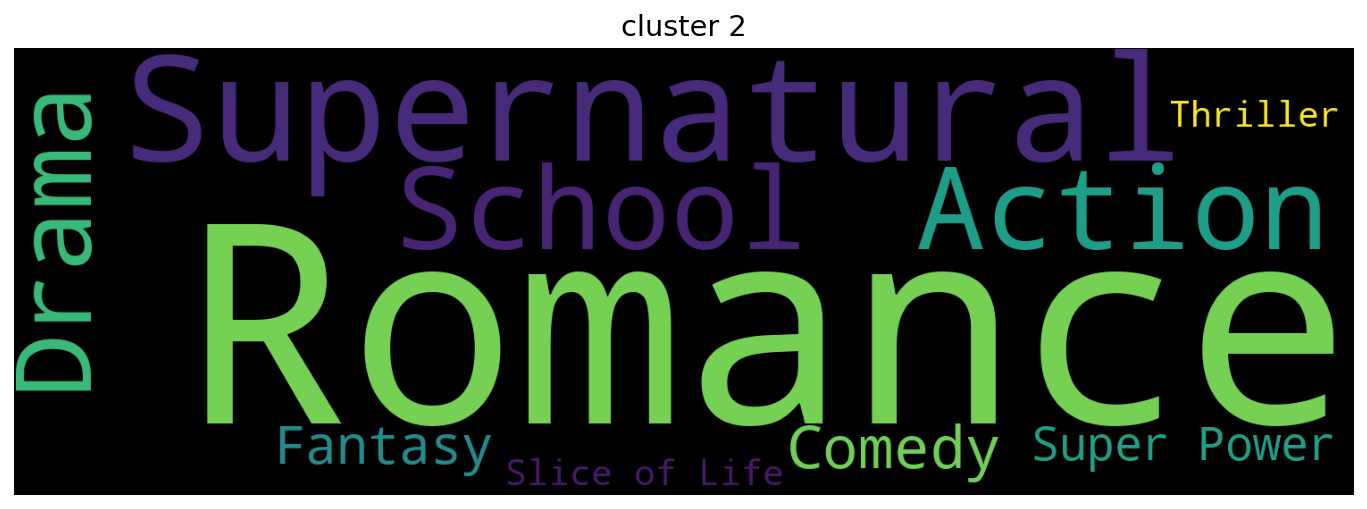

In [0]:
c2_animelist = list(c2.sort_values(ascending=False)[0:15].index)
c2_data = pd.DataFrame()
c2_data['genre'],c2_data['episode'],c2_data['rating'],c2_data['member'] =  createAnimeInfoList(c2_animelist)
c2_data.iloc[:,1:4] = c2_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c2_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 2","black")

In [0]:
keyword_occurences[0:5]

[[' Romance', 7],
 [' Supernatural', 6],
 [' School', 6],
 ['Action', 6],
 [' Drama', 5]]

In [0]:
c2_data['episode'].mean()

20.866666666666667

In [0]:
print('cluster 2\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c2_data['episode'].mean(), c2_data['rating'].mean(),c2_data['member'].mean()))

cluster 2
AVG episode : 20.866666666666667
AVG movie rating : 7.933333333333334
AVG member : 634232.4


### Cluster 3

In [0]:
c3.sort_values(ascending=False)[0:15]

name
Death Note                            0.692794
Code Geass: Hangyaku no Lelouch       0.678245
Fullmetal Alchemist                   0.609338
Code Geass: Hangyaku no Lelouch R2    0.602684
Sen to Chihiro no Kamikakushi         0.598060
Suzumiya Haruhi no Yuuutsu            0.547085
Tengen Toppa Gurren Lagann            0.543476
Cowboy Bebop                          0.528025
Neon Genesis Evangelion               0.523852
Elfen Lied                            0.515845
Fullmetal Alchemist: Brotherhood      0.515732
Mononoke Hime                         0.509755
Toradora!                             0.497801
Howl no Ugoku Shiro                   0.486072
Samurai Champloo                      0.469606
dtype: float64

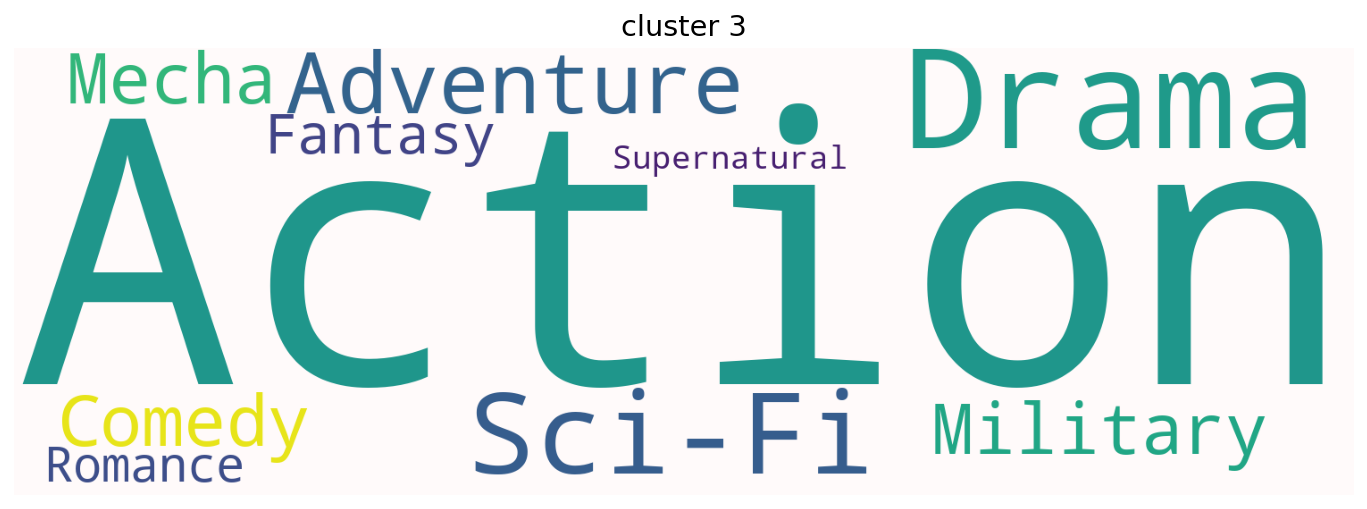

In [0]:
c3_animelist = list(c3.sort_values(ascending=False)[0:15].index)
c3_data = pd.DataFrame()
c3_data['genre'],c3_data['episode'],c3_data['rating'],c3_data['member'] =  createAnimeInfoList(c3_animelist)
c3_data.iloc[:,1:4] = c3_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c3_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 3","snow")

In [0]:
keyword_occurences[0:5]

[['Action', 10],
 [' Drama', 8],
 [' Sci-Fi', 6],
 [' Adventure', 6],
 [' Military', 4]]

In [0]:
print('cluster 3\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c3_data['episode'].mean(), c3_data['rating'].mean(),c3_data['member'].mean()))

cluster 3
AVG episode : 24.133333333333333
AVG movie rating : 8.0
AVG member : 561513.7333333333
